In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm_
from copy import deepcopy
from sklearn import metrics

In [2]:
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [0]:
# define dataset

class SensorlessDataset(Dataset):
  
  def __init__(self, dataframe):
    self.dataset = dataframe.values
    self.dataset = torch.tensor(self.dataset)
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    return self.dataset[idx, :-1].float(), self.dataset[idx, -1].long()


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load data
data_filename = 'gdrive/My Drive/Colab Notebooks/OnlineNewsPopularity/HW2/data/Sensorless_drive_diagnosis.txt'
df = pd.read_csv(data_filename, delimiter=' ', header=None)

In [6]:
# shift class by 1
df['class'] = df[48] - 1

# print number of samples in each class
print('number of samples in each class:\n\n', df['class'].value_counts())

# drop column in -2
df.drop(df.columns[-2], axis=1, inplace=True)


number of samples in each class:

 10    5319
9     5319
8     5319
7     5319
6     5319
5     5319
4     5319
3     5319
2     5319
1     5319
0     5319
Name: class, dtype: int64


In [0]:
# shuffle
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

In [0]:
# define model

class Model(nn.Module):
  def __init__(self, num_features, num_classes):
    super(Model, self).__init__()
    
    self.fc1 = nn.Linear(num_features, 64)
    self.relu1 = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64, 128)
    self.relu2 = nn.ReLU()
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 256)
    self.relu3 = nn.ReLU()
    self.batchnorm3 = nn.BatchNorm1d(256)
    self.fc4 = nn.Linear(256, 256)
    self.relu4 = nn.ReLU()
    self.fc5 = nn.Linear(256, 128)
    self.relu5 = nn.ReLU()
    self.fc6 = nn.Linear(128, 64)
    self.relu6 = nn.ReLU()
    self.fc7 = nn.Linear(64, num_classes)
    
  def forward(self, x):
    x = self.batchnorm1(self.relu1(self.fc1(x)))
    x = self.batchnorm2(self.relu2(self.fc2(x)))
    x = self.batchnorm3(self.relu3(self.fc3(x)))
    x = self.relu4(self.fc4(x))
    x = self.relu5(self.fc5(x))
    x = self.relu6(self.fc6(x))
    x = self.fc7(x)
    return x

In [0]:
# define train method

def train(data_loader, model, optimizer, criterion, curr_epoch, tot_epochs, device):
  
  # set model to training mode
  model.train()
  
  tot_train_loss = 0.0
  
  train_meter = tqdm(
      data_loader, unit=' batches',
      desc=f'[Epoch {curr_epoch}/{tot_epochs}]',
      leave=False
  )
  
  for batch_idx, (sample, label) in enumerate(train_meter):
    
    # transfer to device
    sample, label = sample.to(device), label.to(device)
    
    # zero out gradients
    optimizer.zero_grad()
    
    # forward pass
    out = model(sample)
    
    # compute loss
    loss = criterion(out, label)
    
    # backward
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    # update tqdm meter
    train_meter.set_postfix(train_loss=f'{loss.item():0.4f}')
    train_meter.update()
    
    # add to total train loss
    tot_train_loss = tot_train_loss + loss.item()
    
  av_train_loss = tot_train_loss / (batch_idx + 1)
  return av_train_loss

In [0]:
# define validation method

def validate(data_loader, model, criterion, device):
  
  # set model to eval mode
  model.eval()
  
  tot_val_loss = 0.0
  corrects = 0
  total = 0
  
  val_meter = tqdm(
      data_loader, unit=' batches',
      desc='val',
      leave=False
  )
  
  with torch.no_grad():
    for batch_idx, (sample, label) in enumerate(val_meter):

      # transfer to device
      sample, label = sample.to(device), label.to(device)

      # forward pass
      out = model(sample)

      # compute loss
      loss = criterion(out, label)
      
      # compute the prediction
      max_value, pred = torch.max(out, dim=-1)
      
      # compute number of correct predictions
      corrects += (pred == label).sum().item()

      # update total samples
      total = total + len(label)

      # update tqdm meter
      val_meter.set_postfix(val_loss=f'{loss.item():0.4f}')
      val_meter.update()

      # add to total val loss
      tot_val_loss = tot_val_loss + loss.item()

  av_val_loss = tot_val_loss / (batch_idx + 1)
  accuracy = corrects / total
  return av_val_loss, accuracy

In [0]:
# define predict method

def predict(data_loader, model, criterion, device):
  
  # set model to eval mode
  model.eval()
  
  tot_val_loss = 0.0
  preds = []
  labels = []
  
  val_meter = tqdm(
      data_loader, unit=' batches',
      desc='val',
      leave=False
  )
  
  with torch.no_grad():
    for batch_idx, (sample, label) in enumerate(val_meter):

      # transfer to device
      sample, label = sample.to(device), label.to(device)

      # forward pass
      out = model(sample)

      # compute loss
      loss = criterion(out, label)
      
      # compute the prediction
      max_value, pred = torch.max(out, dim=-1)
      
      # append to preds list
      preds.extend(pred.detach().cpu().tolist())

      # append to labels list
      labels.extend(label.detach().cpu().tolist())

      # update tqdm meter
      val_meter.set_postfix(val_loss=f'{loss.item():0.4f}')
      val_meter.update()

      # add to total val loss
      tot_val_loss = tot_val_loss + loss.item()

  av_val_loss = tot_val_loss / (batch_idx + 1)
  return av_val_loss, preds, labels

In [0]:
# specify learning rate
learning_rate = 0.01

# specify criterion
criterion = nn.CrossEntropyLoss()

In [0]:
# split into train, val and test
df_train, df_val, df_test = df.loc[2000:], df.loc[1000:1999], df.loc[:999]

In [15]:
# create datasets
train_dataset = SensorlessDataset(df_train)
val_dataset = SensorlessDataset(df_val)
test_dataset = SensorlessDataset(df_test)

print('number of samples in each class in training set\n', df_train['class'].value_counts(), '\n\n')
print('number of samples in each class in validation set\n', df_val['class'].value_counts(), '\n\n')
print('number of samples in each class in test set\n', df_test['class'].value_counts())

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

next(iter(train_loader))

number of samples in each class in training set
 8     5169
1     5155
3     5145
0     5145
9     5141
2     5140
7     5137
4     5132
6     5127
10    5113
5     5105
Name: class, dtype: int64 


number of samples in each class in validation set
 5     120
10    108
2      96
3      93
0      91
7      88
6      87
4      86
9      80
1      79
8      72
Name: class, dtype: int64 


number of samples in each class in test set
 6     105
4     101
10     98
9      98
7      94
5      94
1      85
2      83
0      83
3      81
8      78
Name: class, dtype: int64


[tensor([[-5.7030e-06,  9.7712e-07, -1.9322e-05,  ..., -1.4963e+00,
          -1.4963e+00, -1.4963e+00],
         [-1.1116e-06,  5.6079e-05,  4.7567e-04,  ..., -1.4983e+00,
          -1.4984e+00, -1.4980e+00],
         [-3.4473e-06,  1.0009e-04, -3.6345e-04,  ..., -1.4985e+00,
          -1.4985e+00, -1.4985e+00],
         ...,
         [-1.5050e-05, -7.2401e-05,  7.7792e-05,  ..., -1.4983e+00,
          -1.4984e+00, -1.4982e+00],
         [ 4.3115e-06,  8.9324e-06, -1.8507e-06,  ..., -1.4940e+00,
          -1.4940e+00, -1.4939e+00],
         [-4.6724e-06, -1.1002e-07,  5.1380e-05,  ..., -1.5000e+00,
          -1.5000e+00, -1.4996e+00]]),
 tensor([ 9,  1,  5,  9,  2,  4,  7,  2,  9,  3,  3,  6,  9,  7,  4,  2,  3,  5,
          8,  7,  2,  4,  8,  1,  1,  1,  2,  2,  1,  2,  1,  1,  4,  9,  5,  9,
          7,  7, 10,  4,  7,  6, 10,  3,  9,  3,  0,  2,  1,  3,  4,  0,  0,  7,
          3,  4,  3,  5,  2,  2,  7,  4,  6,  7])]

In [21]:
# create model object
model = Model(num_features=48, num_classes=11)

# transfer model to device
model = model.to(device)

# print model
print(89 * '-' + '\n', model, '\n' + 89 * '-')

# print number of parameters
print('number of parameters:', sum(m.numel() for m in model.parameters()))
print(89 * '-')

# create optimizer
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, model.parameters()),
    lr=learning_rate
)

-----------------------------------------------------------------------------------------
 Model(
  (fc1): Linear(in_features=48, out_features=64, bias=True)
  (relu1): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (relu3): ReLU()
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=64, out_features=11, bias=True)
) 
-------------------------------------------------------------------------

In [22]:
# specify max number of epochs
num_epochs = 30

train_losses, val_losses, accs = [], [], []

min_val_loss = np.inf
for epoch in range(1, num_epochs + 1):
  train_loss = train(train_loader, model, optimizer, criterion, epoch, num_epochs, device)
  val_loss, accuracy = validate(val_loader, model, criterion, device)

  if val_loss <= min_val_loss:
    min_val_loss = val_loss
    best_model_weights = deepcopy(model.state_dict())
  
  # check for early stopping
  if all(val_loss > loss for loss in val_losses[-3:]) and len(val_losses) > 2: 
    print('stopping early')
    break
  
  # save losses
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  accs.append(accuracy)
  
  # print losses and accuracies
  tqdm_.write(f'[Epoch {epoch}/{num_epochs}] train loss: {train_loss:0.4f}, val loss: {val_loss:0.4f}, accuracy: {accuracy * 100:0.2f} %')

[Epoch 1/30] train loss: 1.3586, val loss: 0.9327, accuracy: 56.10 %


[Epoch 2/30] train loss: 1.0365, val loss: 1.2498, accuracy: 49.90 %


[Epoch 3/30] train loss: 0.7932, val loss: 0.7056, accuracy: 71.40 %


[Epoch 4/30] train loss: 0.5921, val loss: 0.4657, accuracy: 80.90 %


[Epoch 5/30] train loss: 0.5512, val loss: 0.4661, accuracy: 81.10 %


[Epoch 6/30] train loss: 0.4645, val loss: 0.3582, accuracy: 85.50 %


[Epoch 7/30] train loss: 0.3891, val loss: 0.4026, accuracy: 84.20 %


stopping early


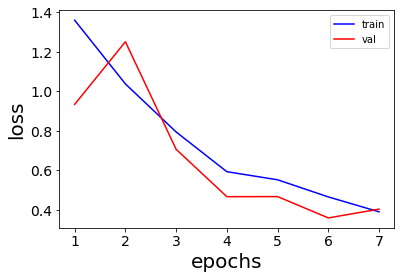

In [23]:
# plot losses
assert len(train_losses) == len(val_losses), 'number of training epochs and validation losses differ'
plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', c='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='val', c='red')
plt.legend()
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xticks(range(1, len(train_losses) + 1), fontsize=14)
plt.yticks(fontsize=14)
plt.show()

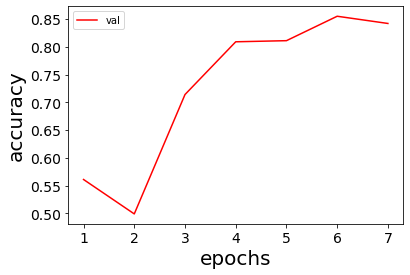

In [24]:
# plot accuracies
plt.plot(range(1, len(accs) + 1), accs, label='val', c='red')
plt.legend()
plt.xlabel('epochs', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.xticks(range(1, len(train_losses) + 1), fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [25]:
# compute test accuracy
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = validate(test_loader, model, criterion, device)
print(f'test loss: {test_loss:0.4}')
print(f'test accuracy: {test_accuracy * 100:.2f} %')

test loss: 0.275
test accuracy: 89.10 %


In [26]:
# compute precision, recall, f1 score
test_loss, preds, labels = predict(test_loader, model, criterion, device)

# precision
print(f'precision: {metrics.precision_score(labels, preds, average="macro") * 100:0.2f} %')

# recall
print(f'recall: {metrics.recall_score(labels, preds, average="macro") * 100:0.2f} %')

# f1 score
print(f'f1 score: {metrics.f1_score(labels, preds, average="macro") * 100:0.2f} %')

precision: 88.83 %
recall: 89.08 %
f1 score: 88.90 %


In [27]:
print('confusion matrix:\n', metrics.confusion_matrix(labels, preds))
print('classification report:\n', metrics.classification_report(labels, preds))

confusion matrix:
 [[ 73   0   0   0   0   9   0   0   1   0   0]
 [  0  73   0   0   0   0   0   0   0  12   0]
 [  0   0  79   2   2   0   0   0   0   0   0]
 [  0   0   0  80   1   0   0   0   0   0   0]
 [  0   0   7   2  79   0   0  13   0   0   0]
 [  8   0   1   0   0  67   0   0  18   0   0]
 [  0   0   0   1   0   0 104   0   0   0   0]
 [  0   0   0   0  10   0   0  84   0   0   0]
 [  0   1   0   0   0  12   0   0  65   0   0]
 [  0   9   0   0   0   0   0   0   0  89   0]
 [  0   0   0   0   0   0   0   0   0   0  98]]
classification report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        83
           1       0.88      0.86      0.87        85
           2       0.91      0.95      0.93        83
           3       0.94      0.99      0.96        81
           4       0.86      0.78      0.82       101
           5       0.76      0.71      0.74        94
           6       1.00      0.99      1.00       105
      